# Contextual Bandit (UCB) - Jester Data

### Import Libraries

In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd


### Sample data function

In [68]:
def sample_jester_data(file_name, context_dim = 32, num_actions = 8, num_contexts = 19181,
shuffle_rows=True, shuffle_cols=False):
    """Samples bandit game from (user, joke) dense subset of Jester dataset.
    Args:
    file_name: Route of file containing the modified Jester dataset.
    context_dim: Context dimension (i.e. vector with some ratings from a user).
    num_actions: Number of actions (number of joke ratings to predict).
    num_contexts: Number of contexts to sample.
    shuffle_rows: If True, rows from original dataset are shuffled.
    shuffle_cols: Whether or not context/action jokes are randomly shuffled.
    Returns:
    dataset: Sampled matrix with rows: (context, rating_1, ..., rating_k).
    opt_vals: Vector of deterministic optimal (reward, action) for each context.
    """
    np.random.seed(0)
    with tf.gfile.Open(file_name, 'rb') as f:
        dataset = np.load(f)
    if shuffle_cols:
        dataset = dataset[:, np.random.permutation(dataset.shape[1])]
    if shuffle_rows:
        np.random.shuffle(dataset)
    dataset = dataset[:num_contexts, :]
    assert context_dim + num_actions == dataset.shape[1], 'Wrong data dimensions.'

    opt_actions = np.argmax(dataset[:, context_dim:], axis=1)
    opt_rewards = np.array([dataset[i, context_dim + a] for i, a in enumerate(opt_actions)])
    return dataset, opt_rewards, opt_actions

### Load Data

In [8]:
dataset, opt_rewards, opt_actions = sample_jester_data('jester_data_40jokes_19181users.npy')

In [10]:
dataset.shape

(19181, 40)

### Train Algorithm

In [69]:
n = 18181 #Remaining 1000 for test
k = 32
n_a = 8

# D = np.random.random((n,k))-0.5
th = np.random.random((n_a,k))-0.5
b = np.zeros_like(th)
A = list()
rewards = [0] * n
choices = [None] * n


for a in range(0,n_a):
    A.append(np.identity(k))
    
p = np.zeros(n_a)
alph = 0.2
th_hat = th
    
for i in range(0,n):
    x_i = dataset[i][:k]
    
    for a in range(0,n_a):
        
        A_inv = np.linalg.inv(A[a])
        th_hat[a] = A_inv.dot(b[a])
        ta = x_i.dot(A_inv.dot(x_i))
        a_upper_ci = alph * np.sqrt(ta)
        a_mean = th_hat[a].dot(x_i)
        p[a] = a_mean + a_upper_ci
        
    p = p+(np.random.random(len(p)) * 0.000001)

    choices[i] = p.argmax()
    
    rewards[i] = dataset[i, k + choices[i]]
    
    A[choices[i]] = A[choices[i]] + np.matmul(x_i, x_i.reshape(k,1))
    b[choices[i]] = b[choices[i]] + rewards[i] * x_i
    
    



Text(0.5,1,'Rolling average reward')

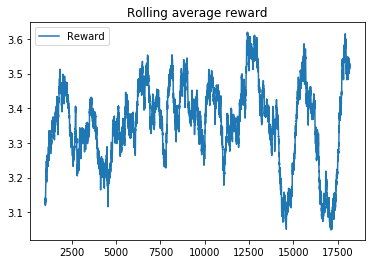

In [70]:
results = pd.DataFrame(rewards)
results.columns = ['Reward']
results.rolling(1000).mean().plot()
plt.title("Rolling average reward")


### Test UCB

In [35]:
opt_actions.shape

(19181,)

In [42]:
dataset[18181]

array([-8.2 , -6.55,  5.24,  3.88, -3.88,  0.29,  5.68, -7.86,  4.42,
       -9.17,  4.76,  0.34, -6.17, -6.46,  1.55, -3.88,  2.72, -8.06,
       -4.66, -0.83, -5.83,  6.8 , -1.02, -4.32,  2.38,  3.98,  2.23,
       -7.62, -8.3 ,  2.04, -8.06, -2.04, -8.98,  1.55, -6.84, -7.38,
       -6.17, -8.25,  7.38,  2.38])

In [49]:
regret = []
corr_choices = []
test_choices = [0]*1000
test_rewards = [0] * 1000
for i in range(n, dataset.shape[0]):
    x_i = dataset[i][:k] # X
        
    
    
    for a in range(0,n_a):
        
        A_inv = np.linalg.inv(A[a])
        th_hat[a] = A_inv.dot(b[a])
        ta = x_i.dot(A_inv.dot(x_i))
        a_upper_ci = alph * np.sqrt(ta)
        a_mean = th_hat[a].dot(x_i)
        p[a] = a_mean + a_upper_ci
        
    p = p+(np.random.random(len(p)) * 0.000001)

    test_choices[i - n] = p.argmax()
    
    test_rewards[i-n] = dataset[i, k + test_choices[i-n]]
    regret.append(opt_rewards[i] - test_rewards[i-n])
    corr_choices.append(int(opt_actions[i]  == test_choices[i-n]))
    

In [53]:
# Optimal Choice proportion
np.mean(corr_choices)

0.219

In [54]:
# Mean Regret
np.mean(regret)

3.01644

### Test Set Evaluation

We see that the proportion of choices that are optimal is 22%, which is a significant improvement over a blind guess of 1/8 = 12.5%.

The mean value for regret in the test set was 3.01.

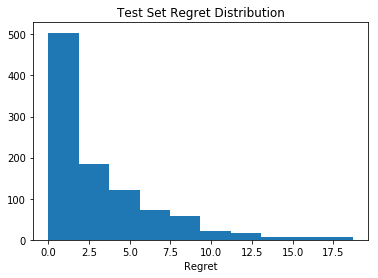

In [56]:
plt.hist(regret)
plt.title("Test Set Regret Distribution")
plt.xlabel("Regret")
plt.show()

The distribution of regret is shown above